# 1. Installing and importing libraries. 
##### Use this link to download the model 'ner_model_az': https://drive.google.com/drive/folders/1cB5CdO6Gll1LwJMzWiGQDcnjNTiA9FdA?usp=sharing

In [ ]:
pip install seqeval

In [ ]:
from transformers import BertTokenizerFast
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset, Features, Value, Sequence
from seqeval.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import ast

# 2. Loading and analyzing dataset

In [ ]:
# Load dataset
ds = load_dataset("LocalDoc/azerbaijani-ner-dataset")

In [ ]:
ds["train"][0]

## As you can see, 'tokens' and 'ner_tags' are stored as long strings that resemble lists. For token classification, they should be converted to actual lists.

In [ ]:
ds["train"].features

{'index': Value('string'),
 'tokens': Value('string'),
 'ner_tags': Value('string')}

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'ner_tags'],
        num_rows: 99545
    })
})


In [ ]:
sample = ds["train"][0]
print("Tokens:", sample["tokens"])
print("NER Tags:", sample["ner_tags"])

Tokens: ['Komitədən', 'bildirilib', 'ki', ',', 'sovet', 'dövründə', 'Azərbaycanda', 'cəmi', '17', 'məscid', 'fəaliyyət', 'göstərirdisə', ',', 'dövlət', 'müstəqilliyinin', 'bərpasından', 'sonra', 'ölkədə', '814', 'məscid', 'tikilib', '.']
NER Tags: [3, 0, 0, 0, 0, 0, 14, 0, 17, 0, 0, 0, 0, 3, 0, 0, 0, 14, 17, 0, 0, 0]


# 3. Preprocessing

## 3.1 Some rows have null tokens and ner tags

In [ ]:
def has_none_fields(example):
    return example["tokens"] is None or example["ner_tags"] is None

# Filter the bad rows only
bad_rows = ds["train"].filter(has_none_fields)

print("Number of null rows: ", len(bad_rows), "\n")

# Display first few problematic rows
for i in range(10):
    print(f"Index: {bad_rows[i]['index']}")
    print(f"Tokens: {bad_rows[i]['tokens']}")
    print(f"NER Tags: {bad_rows[i]['ner_tags']}")
    print("-" * 40)

In [ ]:
# Example bad sample
bad_sample = ds.filter(lambda x: x["index"] == 'dac55265-38cd-4c4b-9e56-a48a77e108d4')
print(bad_sample['train'][0])

## 3.2 In some rows, the lengths of the 'tokens' and 'ner_tags' do not match. This inconsistency must be also considered during parsing.

In [ ]:
# Parse string fields

mismatch_ids = []

def safe_parse_strings(example):
    try:
        tokens = ast.literal_eval(example["tokens"])
        ner_tags = ast.literal_eval(example["ner_tags"])
        tokens = [str(token) for token in tokens]
        ner_tags = [int(tag) for tag in ner_tags]
        if not tokens or not ner_tags:
            print(f"Empty list in example {example['index']}")
            return None
        if len(tokens) != len(ner_tags):
            mismatch_ids.append(example['index'])
            return None
        return {
            "index": example["index"],
            "tokens": tokens,
            "ner_tags": ner_tags,
        }
    except Exception as e:
        # print(f"Parsing error in example {example['index']}: {str(e)} \n")
        # print(f"tokens: {example['tokens']}, ner_tags {example['ner_tags']}")
        return None

parsed_ds = ds.map(safe_parse_strings)

In [ ]:
len(mismatch_ids)

3575

In [ ]:
parsed_ds.shape

{'train': (95953, 3)}

In [ ]:
# Define and apply schema
features = Features({
    "index": Value("string"),
    "tokens": Sequence(Value("string")),
    "ner_tags": Sequence(Value("int32")),
})
parsed_ds = parsed_ds.cast(features)

In [ ]:
parsed_ds

DatasetDict({
    train: Dataset({
        features: ['index', 'tokens', 'ner_tags'],
        num_rows: 95953
    })
})

In [ ]:
# Define label mapping
label_list = [
    "O", "PERSON", "LOCATION", "ORGANISATION", "DATE", "TIME", "MONEY", "PERCENTAGE",
    "FACILITY", "PRODUCT", "EVENT", "ART", "LAW", "LANGUAGE", "GPE", "NORP",
    "ORDINAL", "CARDINAL", "DISEASE", "CONTACT", "ADAGE", "QUANTITY", "MISCELLANEOUS",
    "POSITION", "PROJECT"
]
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for idx, label in enumerate(label_list)}
num_labels = len(label_list)

# Verify unique tags
unique_tags = sorted(set(tag for example in parsed_ds["train"] for tag in example["ner_tags"]))
print("Unique Tags:", unique_tags)
print("Number of Labels:", num_labels)

Unique Tags: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Number of Labels: 25


## 3.3 Loading pretrained model and tokenize and align labels

In [ ]:
# Multilingual BERT model is used as a pretrained model

model_checkpoint = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

In [ ]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128  # change if needed
    )

    word_ids = tokenized.word_ids()
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)  # will be ignored in loss
        elif word_idx != previous_word_idx:
            label_ids.append(example["ner_tags"][word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx

    tokenized["labels"] = label_ids
    return tokenized

tokenized_dataset = parsed_ds.map(tokenize_and_align_labels, batched=False)

## 3.4 Splitting dataset in 7:1:2 ratio

In [ ]:
# First split into train + temp
split = tokenized_dataset["train"].train_test_split(test_size=0.3, seed=42)
train_ds = split["train"]
temp_ds = split["test"]

# Then split temp into val and test (1/3 and 2/3 of 0.3)
val_test_split = temp_ds.train_test_split(test_size=2/3, seed=42)
val_ds = val_test_split["train"]
test_ds = val_test_split["test"]

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Train: 67167 Val: 9595 Test: 19191


# 4. Training

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
from seqeval.metrics import classification_report

# Define metrics

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_predictions = [
        [id2label[p] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(pred, lab) if l != -100]
        for pred, lab in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [ ]:
# Define trainer

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./ner-az",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-21-346797188.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(test_ds)

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORGANISATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ORDINAL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOCATION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: GPE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequen

{'eval_loss': 0.25228703022003174,
 'eval_precision': 0.7066476462196861,
 'eval_recall': 0.6624408248415309,
 'eval_f1': 0.6838305332762739,
 'eval_runtime': 146.3883,
 'eval_samples_per_second': 131.097,
 'eval_steps_per_second': 8.197,
 'epoch': 3.0}

In [ ]:
# Save model, tokenizer, and config
model_path = "./ner_model_az"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model saved to: {model_path}")

Model saved to: ./ner_model_az


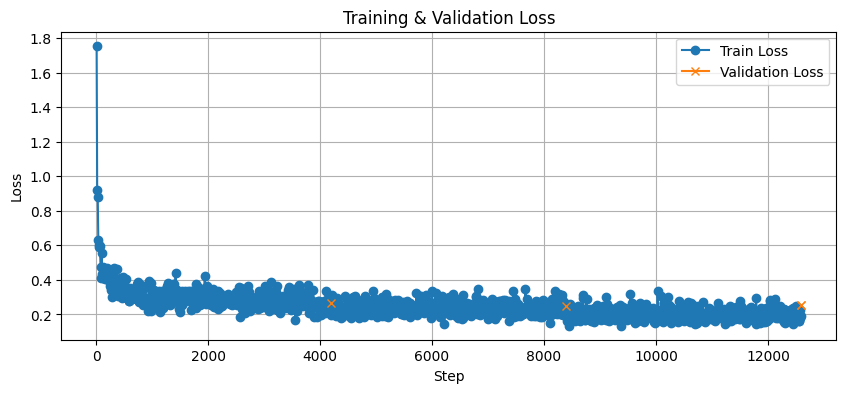

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load logs from the trainer's state
logs = trainer.state.log_history

# Convert to DataFrame
df_logs = pd.DataFrame(logs)

# Plot Losses
plt.figure(figsize=(10, 4))
plt.plot(df_logs["step"], df_logs["loss"], label="Train Loss", marker='o')
if "eval_loss" in df_logs:
    plt.plot(df_logs["step"], df_logs["eval_loss"], label="Validation Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Get predictions
predictions, labels, _ = trainer.predict(test_ds)
preds = predictions.argmax(-1)

true_labels = []
true_preds = []

for pred, label in zip(preds, labels):
    true_label = []
    true_pred = []
    for p, l in zip(pred, label):
        if l != -100:
            true_label.append(id2label[l])
            true_pred.append(id2label[p])
    true_labels.append(true_label)
    true_preds.append(true_pred)

In [ ]:
print(classification_report(true_labels, true_preds))

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     ACILITY       0.45      0.44      0.44      1342
     ANGUAGE       0.68      0.71      0.69       116
     ARDINAL       0.84      0.83      0.84      4257
         ATE       0.68      0.66      0.67      4141
          AW       0.44      0.49      0.46        90
        DAGE       0.00      0.00      0.00        50
   ERCENTAGE       0.69      0.69      0.69       261
       ERSON       0.88      0.85      0.87      6786
         IME       0.61      0.60      0.61       338
ISCELLANEOUS       0.30      0.09      0.14      2974
      ISEASE       0.69      0.67      0.68       552
     OCATION       0.49      0.41      0.44      2367
        ONEY       0.64      0.66      0.65       561
      ONTACT       0.60      0.55      0.57       102
         ORP       0.74      0.80      0.77       945
     OSITION       0.60      0.62      0.61      1494
          PE       0.76      0.83      0.80      6429
      RODUCT       0.52    

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_path = "./ner_model_az"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

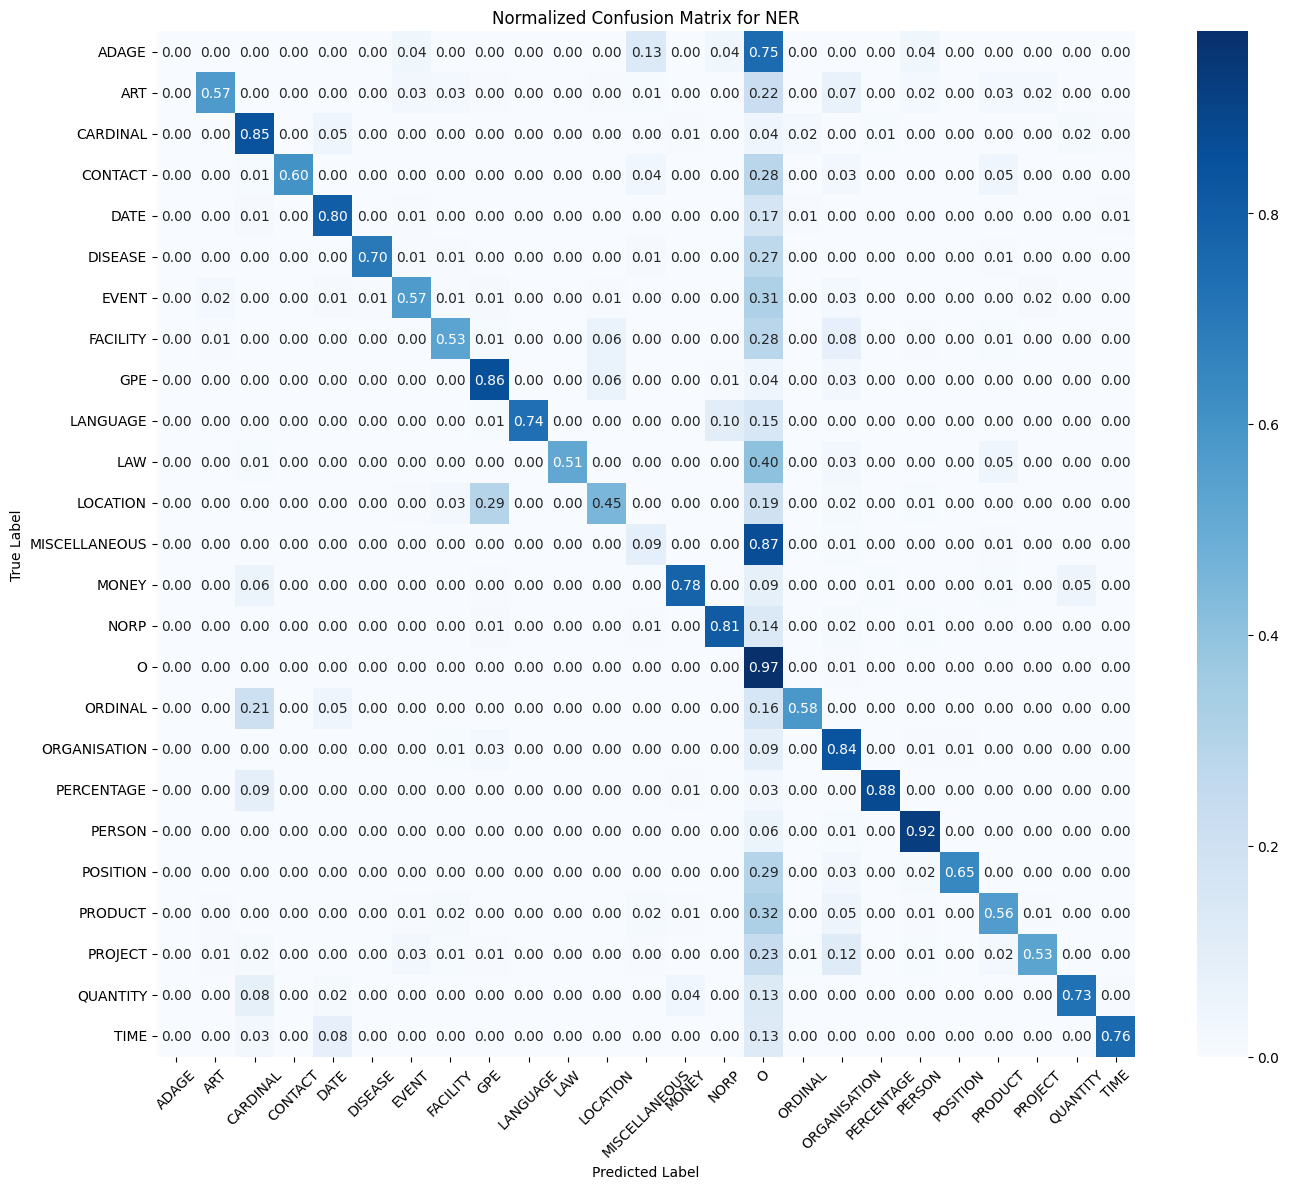

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Flatten labels
flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in true_preds for label in seq]

labels_sorted = sorted(set(flat_true + flat_pred))
label_to_index = {label: i for i, label in enumerate(labels_sorted)}

y_true_idx = [label_to_index[t] for t in flat_true]
y_pred_idx = [label_to_index[p] for p in flat_pred]

cm = confusion_matrix(y_true_idx, y_pred_idx)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=labels_sorted, yticklabels=labels_sorted, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix for NER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from transformers import pipeline

# Load model and tokenizer from saved directory
ner_pipeline = pipeline(
    "ner",
    model="./ner_model_az",
    tokenizer="./ner_model_az",
    aggregation_strategy="simple"  # groups sub-tokens together
)

Device set to use cuda:0


In [ ]:
text = "2025-ci ildə Bakıda F1 keçirilib."
ner_results = ner_pipeline(text)

for entity in ner_results:
    print(f"Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.2f}")

Entity: 2025, Label: DATE, Score: 0.98
Entity: Bakı, Label: GPE, Score: 0.76
Entity: F1, Label: EVENT, Score: 0.71


In [ ]:
text = "Azərbaycan Respublikasının paytaxtı Bakıda, 2024-cü ilin yayında keçirilən beynəlxalq konfrans zamanı, professor Əhmədov, ABŞ-dan gəlmiş qonaqlar və Avropa Birliyinin nümayəndələri ilə ətraf mühitin qorunması strategiyaları haqqında səmərəli müzakirələr apardıqdan sonra, yeni əməkdaşlıq imkanlarının yaranacağını bildirdi."
ner_results = ner_pipeline(text)

for entity in ner_results:
    print(f"Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.2f}")


Entity: Azərbaycan, Label: GPE, Score: 0.95
Entity: pay, Label: POSITION, Score: 0.49
Entity: Bakı, Label: GPE, Score: 0.64
Entity: 2024, Label: DATE, Score: 0.99
Entity: Əhmədov, Label: PERSON, Score: 1.00
Entity: ABŞ, Label: GPE, Score: 0.94
Entity: Avropa, Label: GPE, Score: 0.66
Entity: Birliyi, Label: ORGANISATION, Score: 0.63
